In [1]:
from stravalib.client import Client
import time
import pandas as pd

import seaborn as sns
sns.set(font_scale=2)
sns.set_style("whitegrid")

import matplotlib.pyplot as plt
%matplotlib inline

## Load Data From Strava

## Web access post reuquest Demo (https://developers.strava.com/docs/getting-started/#oauth)
curl -X POST https://www.strava.com/oauth/token \
    -F client_id=40761 \
    -F client_secret=72638d8c256371fea5e3a90819267d838a7de254 \
    -F code=005352d0601908e4ae3f8748141d14583197feb8 \
    -F grant_type=authorization_code

In [2]:
client = Client()
authorize_url = client.authorization_url(client_id=1234, redirect_uri='http://localhost:8282/authorized')
# Have the user click the authorization URL, a 'code' param will be added to the redirect_uri
# .....

# Extract the code from your webapp response

code = '57e0fff2b106d7dbe92246b35936cdcec9b28b1a'
client_id = 40761
client_secret = '72638d8c256371fea5e3a90819267d838a7de254'


# code = request.get('code') # or whatever your framework does
token_response = client.exchange_code_for_token(client_id=client_id, client_secret=client_secret, code=code)
access_token = token_response['access_token']
refresh_token = token_response['refresh_token']
expires_at = token_response['expires_at']

# Now store that short-lived access token somewhere (a database?)
client.access_token = access_token
# You must also store the refresh token to be used later on to obtain another valid access token 
# in case the current is already expired
client.refresh_token = refresh_token

# An access_token is only valid for 6 hours, store expires_at somewhere and
# check it before making an API call.
client.token_expires_at = expires_at
print(f'expires at: {expires_at}')
 
athlete = client.get_athlete()
print("For {id}, I now have an access token {token}".format(id=athlete.id, token=access_token))

if time.time() > client.token_expires_at:
    refresh_response = client.refresh_access_token(client_id=1234, client_secret='asdf1234',
        refresh_token=client.refresh_token)
    access_token = refresh_response['access_token']
    refresh_token = refresh_response['refresh_token']
    expires_at = refresh_response['expires_at']

expires at: 1574061908
For 23066318, I now have an access token 9f4347e4fd566d2493c29e7719086dbf65e8a6ab


## Get some stats on current athlete (me)

In [3]:
client =  Client(access_token=access_token)

In [4]:
print("Hello, {}".format(athlete.firstname))

Hello, Nate


In [5]:
for activity in client.get_activities(after = "2010-01-01T00:00:00Z",  limit=5):
    print("{0.name} {0.moving_time}".format(activity))

Keystone Day 4 3:24:42
Eldora XC skiing 1:58:05
Muddy run w/ Zach 0:56:00
New Albany 0:23:24
Gahanna / New Albany 0:31:45


In [6]:
activity_raw = client.get_activities(limit=1000)

In [7]:
activities = list(activity_raw)

In [8]:
print(len(activities))

152


### Filter On PCT

In [9]:
# Could do a regex to make this more accurate
pct_raw = [a for a in activities if a.name.startswith('Day ')]
pct_raw.reverse()
print([n.name for n in pct_raw[0:5]])

['Day 1 - Campo to Lake Morena', 'Day 2 - Lake Morena to Mount Laguna', 'Day 3 - Mount Laguna to mi. 64', 'Day 4 - mi. 64 to Scissors Crossing', 'Day 6 - Scissors Crossing to Chery’s']


## Data Test

In [10]:
pct = {
    'elev_high' : [a.elev_high for a in pct_raw],
    'elev_low' :  [a.elev_low for a in pct_raw],
    'km': [float(a.distance / 1000) for a in pct_raw],
    'label': [a.name for a in pct_raw],
    'total_elevation_gain': [float(a.total_elevation_gain) for a in pct_raw],
    'activity_id': [a.id for a in pct_raw]
}
pct = pd.DataFrame.from_dict(pct).dropna()
pct.head(20)

,activity_id,elev_high,elev_low,km,label,total_elevation_gain
0,2378776144,1075.2,720.2,32.0125,Day 1 - Campo to Lake Morena,945.0
1,2381822935,1833.2,916.4,36.4034,Day 2 - Lake Morena to Mount Laguna,1390.0
2,2386383299,1842.6,1198.2,33.7508,Day 3 - Mount Laguna to mi. 64,832.0
3,2386388247,1321.4,698.2,20.9330,Day 4 - mi. 64 to Scissors Crossing,509.0
4,2392234232,1311.2,683.8,39.5964,Day 6 - Scissors Crossing to Chery’s,1023.0
5,2394319741,1085.6,929.8,14.9767,Day 7 - Chery’s to Warner Springs,285.0
6,2406772692,1590.4,886.4,30.7184,Day 10 - Warner Springs to Mike’s Place,1090.0
7,2406777884,1702.4,1039.8,28.8674,Day 11 - Mike’s Place to Mary’s,691.0
8,2406779870,1525.0,1351.4,11.2874,Day 12 - Mary’s to Paradise Valley Cafe,332.0
9,2413022182,3051.8,1461.8,15.1079,Day 13 - Idyllwild to Mount San Jacinto,1315.0


### Deal With Dirty data (is it just elevation on day 63?)

In [11]:
bad_data_filter = pct.elev_high - pct.elev_low > 5000
print(f'Dropping Bad Data: {pct[bad_data_filter]}')
pct = pct[~bad_data_filter]

Dropping Bad Data:     activity_id  elev_high  elev_low      km                      label  \
54   2568157061     4998.6    -500.0  47.436  Day 63 - mi 147 to mi 178   

    total_elevation_gain  
54                1805.0  


In [12]:
#  Note: Added the "if" condition because there seems to be a bad day
y_plot_data = [(y_min, y_max) for y_min, y_max  in zip(pct.elev_low, pct.elev_high)]

/Users/zac/.pyenv/versions/3.6.3/lib/python3.6/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


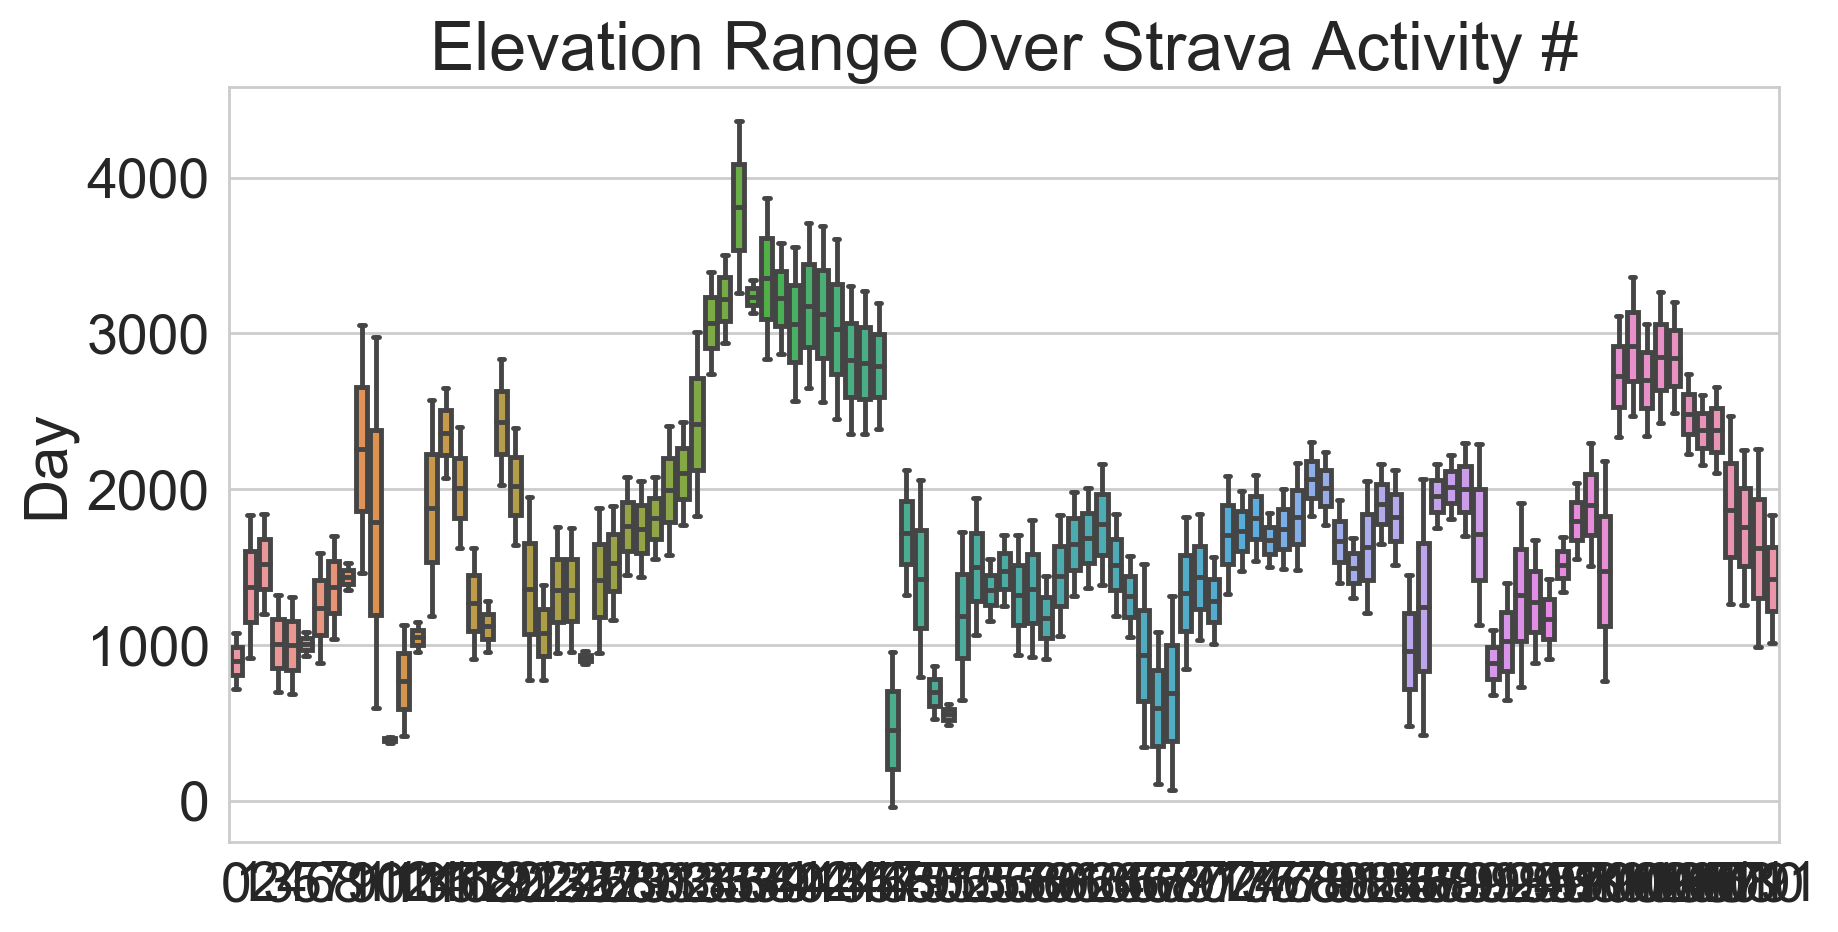

In [13]:
f, axarr = plt.subplots(figsize=(10, 5), dpi=200)
sns.boxplot(x=pct.index, y=y_plot_data)
plt.title('Elevation Range Over Strava Activity #')
axarr.set_ylabel('Meters')
axarr.set_ylabel('Day')
plt.show()

In [26]:
pct.km.mean()

36.050513513513515

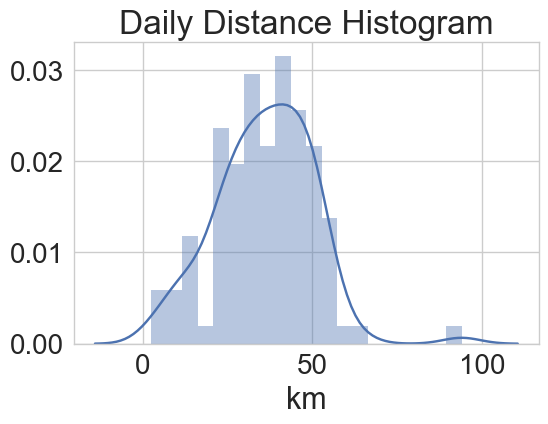

In [46]:
f, axarr = plt.subplots(figsize=(6, 4), dpi=100)
plt.title('Daily Distance Histogram')
sns.distplot(pct.km, bins=20)
plt.show()

In [63]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FormatStrFormatter

def build_pct_historgram(base_data=pct.km, default_dpi=500, lower_percentile=25, upper_percentile=75):
    data = base_data
    fig, ax = plt.subplots(figsize=(20, 8), dpi=default_dpi)
    counts, bins, patches = ax.hist(data, facecolor='yellow', edgecolor='gray')

    ax.set_xticks(bins)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))

    lower_color_change_percentile, upper_color_change_percentile = np.percentile(data, [lower_percentile, upper_percentile])
    for patch, right_side, left_side in zip(patches, bins[1:], bins[:-1]):
        if right_side < lower_color_change_percentile:
            patch.set_facecolor('green')
        elif left_side > upper_color_change_percentile:
            patch.set_facecolor('red')

    # Label the raw counts and the percentages below the x-axis...
    bin_centers = 0.5 * np.diff(bins) + bins[:-1]
    for count, x in zip(counts, bin_centers):
        # Label the raw counts
        ax.annotate(str(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
            xytext=(0, -18), textcoords='offset points', va='top', ha='center')

        # Label the percentages
        percent = '%0.0f%%' % (100 * float(count) / counts.sum())
        ax.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
            xytext=(0, -40), textcoords='offset points', va='top', ha='center')


    # Give ourselves some more room at the bottom of the plot
    plt.subplots_adjust(bottom=0.15)
    plt.title('Daily Distance Histogram: ' + str("Mean Diatance = ") + str(pct.km.mean()))
    plt.xlabel('Kilometers', labelpad=50)
    plt.ylabel('Bin Count')
    plt.show()

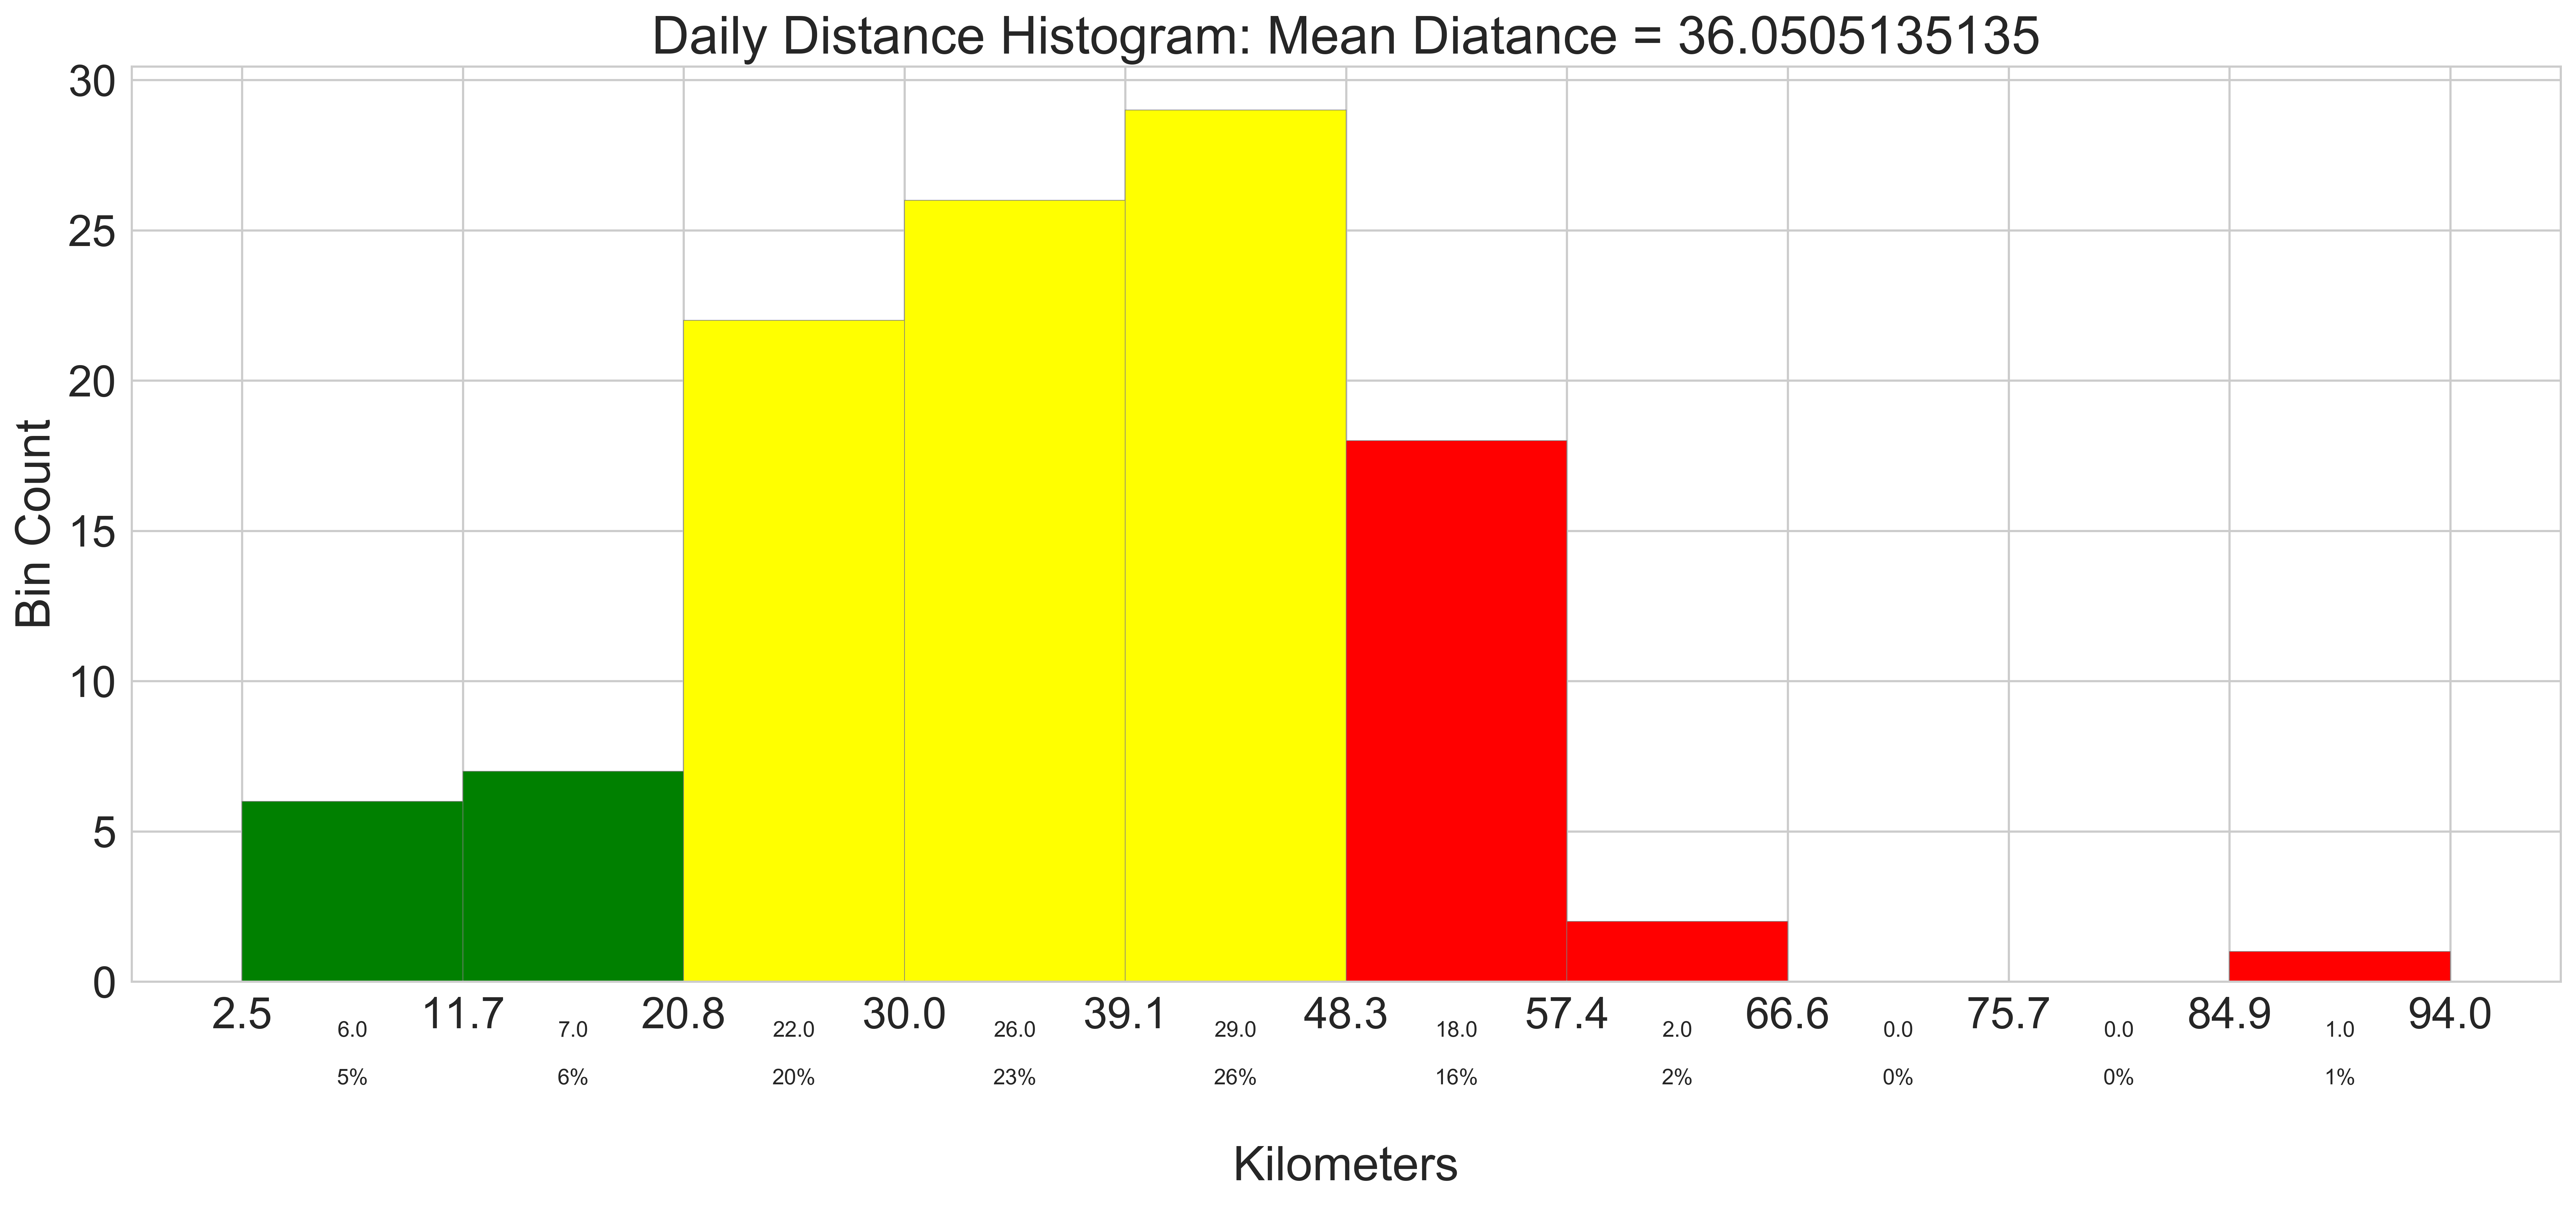

In [64]:
build_pct_historgram()

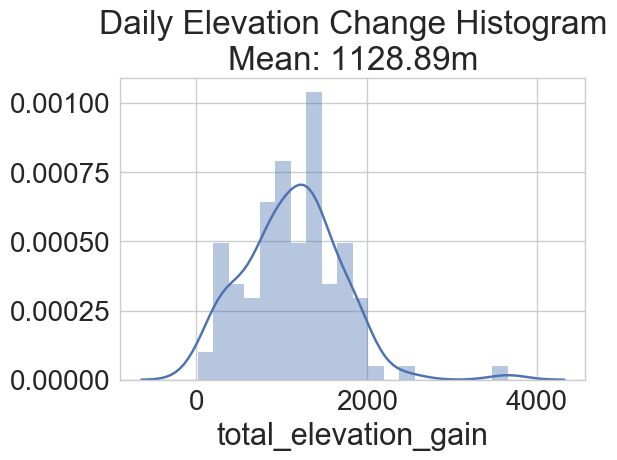

In [16]:
f, axarr = plt.subplots(figsize=(6, 4), dpi=100)
plt.title(f'Daily Elevation Change Histogram\nMean: {pct.total_elevation_gain.mean():.2f}m')
sns.distplot(pct.total_elevation_gain, bins=20)
plt.show()

In [17]:
km_to_mi = 0.621371
total_pct_miles = 2663
mpd = pct.km.mean() * 0.621371
total_distance_mi = sum(pct.km) * 0.621371
bias = total_distance_mi / total_pct_miles

print(f'Miles Per Day: {mpd:.2f}')
print(f'Total Measured Distance: {total_distance_mi:g} mi')
print(f'Real Distance: {total_pct_miles} mi')
print(f'Recording Bias: {bias*100:0.2f}% of total mileage recorded')


Miles Per Day: 22.40
Total Measured Distance: 2486.48 mi
Real Distance: 2663 mi
Recording Bias: 93.37% of total mileage recorded


### Zeros/Neros
Task: Regex out day#, then create distance=0 rows for zero days

### High Fidelity Activity Data

In [18]:
sample_id = 2378776144 # Day 1
types = ['time', 'latlng', 'altitude', 'heartrate', 'temp', 'velocity_smooth']
sample_stream = client.get_activity_streams(activity_id=sample_id, types=types)

In [19]:
sample_stream

{'altitude': <Stream type=altitude resolution=high original_size=8407>,
 'distance': <Stream type=distance resolution=high original_size=8407>,
 'heartrate': <Stream type=heartrate resolution=high original_size=8407>,
 'latlng': <Stream type=latlng resolution=high original_size=8407>,
 'temp': <Stream type=temp resolution=high original_size=8407>,
 'time': <Stream type=time resolution=high original_size=8407>,
 'velocity_smooth': <Stream type=velocity_smooth resolution=high original_size=8407>}

In [20]:
sample_stream['distance'].data[-1]

32012.5

In [21]:
sample_stream['time'].data[-1]

30041

In [22]:
meters_per_second_to_miles_per_hour = 

SyntaxError: invalid syntax (<ipython-input-22-dfd31c4b865c>, line 1)

In [ ]:
sample_stream['distance'].data[-1] / sample_stream['time'].data[-1] * 

In [ ]:
stream_data